In [1]:
import os 
import time

import pandas as pd
import numpy as np

import nltk

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn_crfsuite.metrics import flat_classification_report              

SEED = 42

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd gdrive/MyDrive/coursework/original_datasets

/content/gdrive/MyDrive/coursework/original_datasets


In [4]:
train_path =  "scienceie2017_train/train2"
test_path = "semeval_articles_test"
glove_path = "glove.6B/glove.6B.300d.txt"      #used 300d (giving the best results)
#test_path = "/content/gdrive/MyDrive/coursework/original_datasets/scienceie2017_dev/dev"    #This is dev path

In [5]:
#https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html

from reader import ScienceIEBratReader          #read the files
from extras import VSM                          #https://www.kaggle.com/stacykurnikova/using-glove-embedding  [source of the code]
from extras import utf8ify, read_and_map        #map it with the embeddings 
from representation import ConcatMapper         

In [6]:
glove = VSM(glove_path)    #Glove 300.d is used

In [7]:
cs = 4
SB =True
domain_file = None

In [8]:
mapper = ConcatMapper(glove, cs, sentence_boundaries = True)

In [ ]:
X_train, Y_train, Y_values, _ = read_and_map(train_path, mapper, domain_file = domain_file)
print("Done")

In [10]:
Y_train

array([0, 1, 2, ..., 0, 0, 1])

In [11]:
nclasses = len(Y_values)

In [12]:
X_train

array([[ 0.        ,  0.        ,  0.        , ...,  0.059717  ,
        -0.22853   ,  0.29602   ],
       [ 0.        ,  0.        ,  0.        , ..., -0.24131   ,
        -0.40402001,  0.054744  ],
       [-0.1749    ,  0.22956   ,  0.24924   , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.04656   ,  0.21318001, -0.0074364 , ..., -0.038572  ,
        -0.058197  , -0.44977   ],
       [-0.16843   , -0.037651  , -0.17304   , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04656   ,  0.21318001, -0.0074364 , ..., -0.2881    ,
         0.44391999,  0.0032899 ]])

In [13]:
Y_values

['Task', 'Process', 'Material']

In [14]:
nclasses

3

In [ ]:
X_test, Y_test, _, entities = read_and_map(test_path, mapper, Y_values, domain_file = domain_file)
print("Done")

In [16]:
print(nclasses)

3


In [17]:
classifiers = [
            RandomForestClassifier(n_estimators = 100, n_jobs = -1, criterion = 'gini'), 
           RandomForestClassifier(n_estimators = 100, n_jobs = -1, criterion = 'entropy'),
            ExtraTreesClassifier(n_estimators = 100, n_jobs = -1, criterion = 'gini'),
            ExtraTreesClassifier(n_estimators = 100, n_jobs = -1, criterion = 'entropy'),
            xgb.XGBClassifier(n_estimators = 50, silent = False, objective = 'multi:softprob')
            ]

In [18]:
classifiers

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                        warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
              

In [19]:
nfolds = 10
rskf = StratifiedKFold(n_splits = nfolds, shuffle = True, random_state = SEED)

In [20]:
dataset_train_list = []
for j, clf in enumerate(classifiers):
  dataset_train_list.append(np.zeros((X_train.shape[0], nclasses-1 )))

In [21]:
dataset_test_list = []
for j, clf in enumerate(classifiers):
  dataset_test_list.append(np.zeros((X_test.shape[0], nclasses - 1 )))

In [22]:
for j, clf in enumerate(classifiers):
  print(j, clf)
  dataset_test_j_list = []
        
  for ii in range(nfolds):
    dataset_test_j_list.append(np.zeros((X_test.shape[0], nclasses-1)))
  
  for i, (train, test) in enumerate(rskf.split(X_train, Y_train)):
    print("Fold Number : ", (i+1))

    
    X_train_New = X_train[train]
    Y_train_New = Y_train[train]            
    X_test_New = X_train[test]
    Y_test_New = Y_train[test]
            
    clf.fit(X_train_New, Y_train_New)
                    
    pred_prob_list = clf.predict_proba(X_test_New)
            
    cf = confusion_matrix(Y_test_New, clf.predict(X_test_New))
    #print(cf)
                    
    dataset_train_list[j][test] = pred_prob_list[:,:-1]
            
    #print(dataset_train_list[j].shape)
            
    dataset_test_j_list[i][:, :] = clf.predict_proba(X_test)[:,:-1]
            
  temp = 0
  for ff in range(nfolds):
    temp += dataset_test_j_list[ff]
  #print(temp)

    
  dataset_test_list[j] = temp/nfolds

0 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Fold Number :  1
Fold Number :  2
Fold Number :  3
Fold Number :  4
Fold Number :  5
Fold Number :  6
Fold Number :  7
Fold Number :  8
Fold Number :  9
Fold Number :  10
1 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_s

In [23]:
len(dataset_train_list) == len(dataset_test_list)

True

In [24]:
blend_train = np.c_[dataset_train_list[0], dataset_train_list[1], dataset_train_list[2], dataset_train_list[3], dataset_train_list[4]]
blend_test = np.c_[dataset_test_list[0], dataset_test_list[1], dataset_test_list[2], dataset_test_list[3], dataset_test_list[4]]

In [25]:
classifiers

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                        warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
              

In [26]:
TEST_Z = X_test

In [27]:
base_pred = []
for i in classifiers:
  base_pred.append(i.predict_proba(TEST_Z)[ : , : -1])

In [28]:
test_MClassifier = np.c_[base_pred[0], base_pred[1]]#, base_pred[2], base_pred[3], base_pred[4]]

In [29]:
Y_train_OneHot = np.zeros((len(Y_train), nclasses))
Y_train_OneHot[np.arange(len(Y_train)), Y_train] = 1
Y_test_OneHot = np.zeros((len(Y_test), nclasses))
Y_test_OneHot[np.arange(len(Y_test)), Y_test] = 1

In [30]:
def model_with_Validation(X_total, Y_total, X_test = None, Y_test = None, hiddenDim = 250):
   
    X_train, X_dev, Y_train, Y_dev = train_test_split(X_total, Y_total, test_size = 0.10, random_state = SEED)

    
    model = Sequential()


    model.add(Dense(input_dim = X_train.shape[1], units = 250))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Dense(units = 3))
    model.add(Activation("softmax"))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adamax', metrics = ['accuracy'])

    weightsPath = "./tmp/myfooo2%s.dat"%(time.time())
    #weightsPath = "results/check/model"
    checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1, save_best_only=True)

    model.fit(X_train, Y_train, verbose = 2,  epochs = 10, batch_size = 32, validation_data = (X_dev,Y_dev), callbacks = [checkpointer])            #,callbacks=[checkpointer])

    model.load_weights(weightsPath)
    loss, acc = model.evaluate(X_test, Y_test, batch_size=32)
   
    print("loss : %0.5f Accuracy :%0.5f"%(loss,acc))

    model.summary()


    cf = confusion_matrix(Y_test[ : , 1], model.predict_classes(X_test))
    #print(cf)
    predictions = model.predict_classes(X_test)
    print("-------------->",predictions)
    
    return model, predictions

In [31]:
hiddenDim = 20
mymodel, Y_results = model_with_Validation(
                                      blend_train, Y_train_OneHot,
                                       blend_test, Y_test_OneHot,
                                       hiddenDim = hiddenDim
                                       )

Epoch 1/10
190/190 - 18s - loss: 0.7167 - accuracy: 0.6859 - val_loss: 0.9552 - val_accuracy: 0.6686

Epoch 00001: val_loss improved from inf to 0.95520, saving model to ./tmp/myfooo21622066146.9842224.dat
INFO:tensorflow:Assets written to: ./tmp/myfooo21622066146.9842224.dat/assets
Epoch 2/10
190/190 - 0s - loss: 0.6964 - accuracy: 0.6977 - val_loss: 0.7925 - val_accuracy: 0.6835

Epoch 00002: val_loss improved from 0.95520 to 0.79249, saving model to ./tmp/myfooo21622066146.9842224.dat
INFO:tensorflow:Assets written to: ./tmp/myfooo21622066146.9842224.dat/assets
Epoch 3/10
190/190 - 0s - loss: 0.6885 - accuracy: 0.6988 - val_loss: 0.7113 - val_accuracy: 0.6999

Epoch 00003: val_loss improved from 0.79249 to 0.71131, saving model to ./tmp/myfooo21622066146.9842224.dat
INFO:tensorflow:Assets written to: ./tmp/myfooo21622066146.9842224.dat/assets
Epoch 4/10
190/190 - 0s - loss: 0.6900 - accuracy: 0.6985 - val_loss: 0.6977 - val_accuracy: 0.7043

Epoch 00004: val_loss improved from 0.711

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


--------------> [1 1 1 ... 2 2 2]


In [32]:
results = []
print("====PREDICTING====")
for i in range(len(Y_test)):
  results.append(Y_values[Y_results[i]])
  print(Y_values[Y_results[i]])

====PREDICTING====
Process
Process
Process
Process
Task
Material
Process
Material
Process
Process
Material
Material
Material
Process
Process
Material
Process
Process
Material
Process
Material
Process
Process
Material
Material
Material
Process
Process
Material
Task
Material
Process
Process
Process
Material
Process
Process
Process
Process
Process
Material
Process
Process
Process
Material
Process
Process
Material
Material
Process
Process
Process
Material
Material
Material
Process
Task
Process
Process
Process
Process
Process
Process
Process
Process
Process
Material
Process
Material
Process
Process
Process
Process
Process
Task
Material
Process
Material
Material
Material
Material
Material
Process
Process
Process
Material
Material
Process
Material
Material
Material
Material
Material
Process
Material
Process
Process
Process
Material
Process
Material
Material
Material
Process
Task
Task
Process
Material
Task
Process
Task
Material
Material
Task
Process
Material
Process
Process
Process
Material
Ma

In [33]:
actual = []
print("====ACTUAL====")
for i in range(len(Y_test)):
  actual.append(Y_values[Y_test[i]])
  print(Y_values[Y_test[i]])

====ACTUAL====
Process
Process
Process
Process
Task
Process
Process
Material
Material
Process
Material
Material
Material
Material
Process
Material
Process
Process
Material
Material
Process
Material
Material
Process
Process
Material
Material
Process
Material
Task
Material
Material
Process
Material
Material
Process
Process
Material
Process
Material
Material
Material
Process
Process
Material
Material
Process
Process
Process
Process
Material
Process
Process
Process
Material
Process
Process
Material
Task
Process
Process
Process
Process
Process
Process
Process
Process
Task
Process
Process
Process
Process
Process
Process
Task
Process
Process
Material
Material
Material
Material
Material
Process
Process
Process
Material
Process
Process
Process
Process
Process
Material
Material
Process
Material
Material
Process
Process
Material
Process
Material
Material
Material
Task
Process
Process
Process
Material
Process
Task
Task
Task
Task
Task
Task
Task
Task
Task
Task
Material
Material
Material
Process
Mate

In [34]:
cm = confusion_matrix(actual, results, labels = ["Material", "Task", "Process"])
cm

array([[695,   3, 206],
       [ 33,  66,  95],
       [250,  38, 665]])

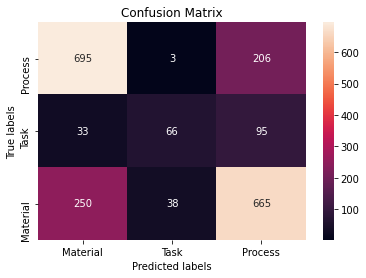

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot = True, fmt = 'g', ax = ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Material', 'Task', "Process"]); ax.yaxis.set_ticklabels(['Process', 'Task', 'Material']);

In [36]:
print("F1-score is : {:.1%}".format(f1_score(Y_test, Y_results, average = "micro")))

F1-score is : 69.5%
